In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
plt.style.use('fivethirtyeight')
from keras.optimizers import Adam


In [16]:
df = pd.read_csv('seattle-weather.csv')
df_1 = df[df['weather']!='rain']
df_1.head(10)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
7,2012-01-08,0.0,10.0,2.8,2.0,sun
10,2012-01-11,0.0,6.1,-1.1,5.1,sun
11,2012-01-12,0.0,6.1,-1.7,1.9,sun
12,2012-01-13,0.0,5.0,-2.8,1.3,sun
13,2012-01-14,4.1,4.4,0.6,5.3,snow
14,2012-01-15,5.3,1.1,-3.3,3.2,snow
15,2012-01-16,2.5,1.7,-2.8,5.0,snow
16,2012-01-17,8.1,3.3,0.0,5.6,snow
17,2012-01-18,19.8,0.0,-2.8,5.0,snow


In [17]:
print(df.shape)
print(df.info())
print(df.isnull().sum())
print(df.duplicated().sum())
df.describe()

(1461, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64
0


,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [18]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.drop(columns=['date'], inplace=True)

le = LabelEncoder()
df['weather'] = le.fit_transform(df['weather'])
df['weather'].value_counts()

weather
2    641
4    640
1    101
0     53
3     26
Name: count, dtype: int64

In [19]:
df.columns

Index(['precipitation', 'temp_max', 'temp_min', 'wind', 'weather', 'year',
       'month', 'day'],
      dtype='object')

In [20]:
X = df[['precipitation', 'temp_max', 'temp_min', 'wind', 'year', 'month', 'day']].values
y = df['weather'].values

In [21]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
import joblib
joblib.dump(scaler, "minmax_scaler.pkl")

['minmax_scaler.pkl']

In [23]:
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [26]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [27]:
num_classes = y_train.shape[1]

model_LSTM = Sequential()

model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model_LSTM.add(Dropout(0.5))

model_LSTM.add(LSTM(units=50, return_sequences=True))
model_LSTM.add(Dropout(0.5))

model_LSTM.add(LSTM(units=50, return_sequences=True))
model_LSTM.add(Dropout(0.5))

model_LSTM.add(LSTM(units=50))
model_LSTM.add(Dropout(0.5))

model_LSTM.add(Dense(units=num_classes, activation='softmax'))

/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,455 (283.03 KB)

 Trainable params: 72,455 (283.03 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_LSTM = model_LSTM.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4077 - loss: 1.5925 - val_accuracy: 0.4615 - val_loss: 1.5169
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4574 - loss: 1.4440 - val_accuracy: 0.4615 - val_loss: 1.0969
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4182 - loss: 1.1701 - val_accuracy: 0.4188 - val_loss: 1.0894
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3966 - loss: 1.1199 - val_accuracy: 0.4615 - val_loss: 1.0906
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4336 - loss: 1.1018 - val_accuracy: 0.4615 - val_loss: 1.0934
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4229 - loss: 1.0982 - val_accuracy: 0.4188 - val_loss: 1.0955
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4469 - loss: 1.0688 - val_accuracy: 0.4188 - val_loss: 1.0957
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4657 - loss: 1.1077 - val_accuracy: 0.4615 - 

In [30]:
loss, acc = model_LSTM.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8191 - loss: 0.4867
Test Accuracy: 82.59%


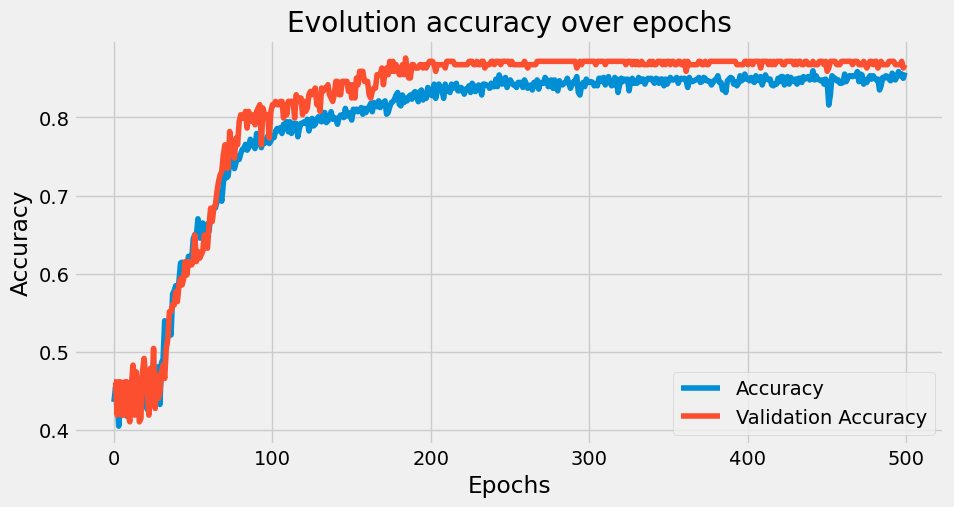

In [31]:
plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['accuracy'], label='Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.title("Evolution accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
sample = np.array([[0.2, 18.0, 10.0, 3.5, 2024, 5, 12]])  # precipitation, temp_max, temp_min, wind, year, month, day
sample_scaled = scaler.transform(sample)
sample_scaled = sample_scaled.reshape((1, 1, sample_scaled.shape[1]))

prediction = model_LSTM.predict(sample_scaled)
pred_class = np.argmax(prediction)
print("Prediction :", le.inverse_transform([pred_class])[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Prediction : rain


In [32]:
model_LSTM.save("weather_lstm_model.h5")

### GRU



In [33]:
# The GRU architecture
model_GRU = Sequential()
# First GRU layer with Dropout regularisation
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))

model_GRU.add(Dropout(0.2))
# Second GRU layer
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))
# Third GRU layer
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))
# Fourth GRU layer
model_GRU.add(GRU(units=50, activation='tanh'))
model_GRU.add(Dropout(0.2))
# The output layer
model_GRU.add(Dense(units=num_classes, activation='softmax'))

In [34]:
model_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_GRU.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 50)          │         8,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1, 50)          │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1, 50)          │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,005 (214.86 KB)

 Trainable params: 55,005 (214.86 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history_GRU = model_GRU.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4336 - loss: 1.5393 - val_accuracy: 0.4188 - val_loss: 1.1370
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4340 - loss: 1.1263 - val_accuracy: 0.4487 - val_loss: 1.0874
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4230 - loss: 1.1192 - val_accuracy: 0.4402 - val_loss: 1.0917
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4598 - loss: 1.0532 - val_accuracy: 0.4872 - val_loss: 1.0903
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4808 - loss: 1.0542 - val_accuracy: 0.5470 - val_loss: 1.0845
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4783 - loss: 1.0633 - val_accuracy: 0.5598 - val_loss: 1.0608
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5733 - loss: 1.0117 - val_accuracy: 0.5812 - val_loss: 1.0070
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6183 - loss: 0.9859 - val_accuracy: 0.6197 - 

In [36]:
loss, acc = model_GRU.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.8382 - loss: 0.5262
Test Accuracy: 85.67%


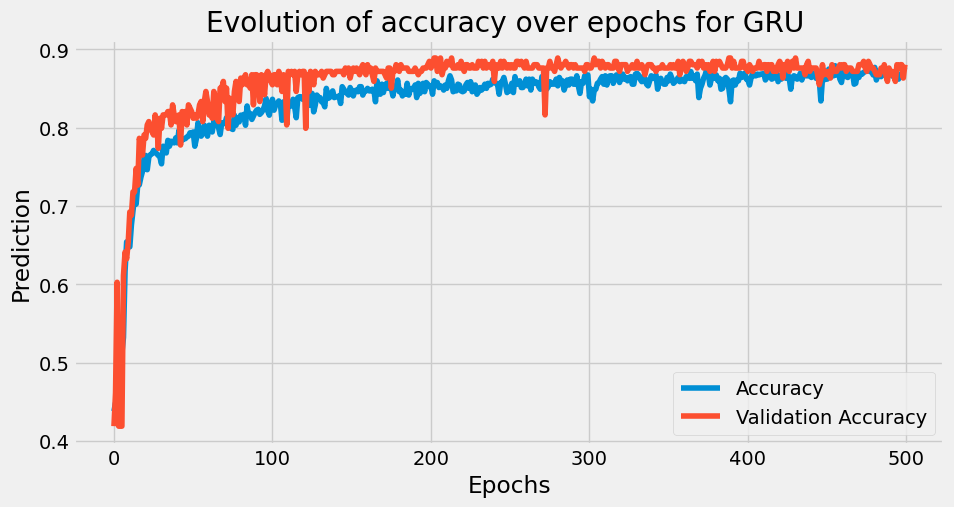

In [25]:
plt.figure(figsize=(10,5))
plt.plot(history_GRU.history['accuracy'], label='Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.title("Evolution of accuracy over epochs for GRU ")
plt.xlabel("Epochs")
plt.ylabel("Prediction")
plt.legend()
plt.show()

In [37]:
model_GRU.save("weather_gru_model.h5")

### GRU Encoder Decoder

In [28]:
num_classes = y_train.shape[1]
timesteps = X_train.shape[1]
features = X_train.shape[2]

# ===== ENCODER =====
encoder_inputs = Input(shape=(timesteps, features))
encoder_gru = GRU(50, return_state=True, dropout=0.2)
encoder_outputs, state_h = encoder_gru(encoder_inputs)

# ===== DECODER =====
decoder_inputs = RepeatVector(timesteps)(encoder_outputs)
decoder_gru = GRU(50, return_sequences=True, dropout=0.2)
decoder_outputs = decoder_gru(decoder_inputs, initial_state=[state_h])

decoder_dense = TimeDistributed(Dense(50, activation='relu'))(decoder_outputs)
decoder_final = Dense(num_classes, activation='softmax')(decoder_dense[:, -1, :])

model_RNN_EncDec_GRU = Model(encoder_inputs, decoder_final)

In [29]:
model_RNN_EncDec_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Résumé
model_RNN_EncDec_GRU.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ [(None, 50),      │      8,850 │ input_layer_3[0]… │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 1, 50)     │          0 │ gru_6[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 1, 50)     │     15,300 │ repeat_vector_1[… │
│                     │                   │            │ gru_6[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 50)     │      2,550 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 50)        │          0 │ time_distributed… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │        255 │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,955 (105.29 KB)

 Trainable params: 26,955 (105.29 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_RNN_EncDec = model_RNN_EncDec_GRU.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3885 - loss: 1.5133 - val_accuracy: 0.4701 - val_loss: 1.1557
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4738 - loss: 1.1133 - val_accuracy: 0.4316 - val_loss: 1.0887
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5223 - loss: 1.0431 - val_accuracy: 0.5940 - val_loss: 1.0674
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5868 - loss: 1.0477 - val_accuracy: 0.5513 - val_loss: 1.0329
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6061 - loss: 1.0410 - val_accuracy: 0.6154 - val_loss: 0.9978
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5981 - loss: 0.9649 - val_accuracy: 0.6026 - val_loss: 0.9808
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5529 - loss: 0.9543 - val_accuracy: 0.6880 - val_loss: 0.9478
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6175 - loss: 0.9365 - val_accuracy: 0.6581 - v

In [31]:
loss, acc = model_RNN_EncDec_GRU.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7908 - loss: 0.4843
Test Accuracy: 80.55%


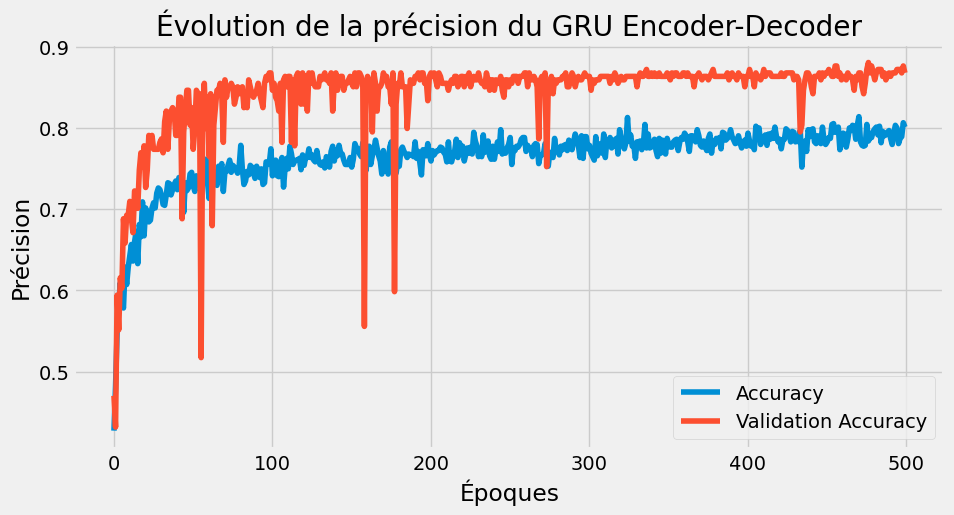

In [32]:
plt.figure(figsize=(10,5))
plt.plot(history_RNN_EncDec.history['accuracy'], label='Accuracy')
plt.plot(history_RNN_EncDec.history['val_accuracy'], label='Validation Accuracy')
plt.title("Évolution de la précision du GRU Encoder-Decoder")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()
plt.show()